<a href="https://colab.research.google.com/github/kinepipe/AMH/blob/main/COP_24_rev_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Archivos disponibles:
1. OJOS ABIERTOS DARA.csv
2. OJOS CERRADOS  SISSY.csv
3. OJOS ABIERTO JAVIERA.csv
4. OJOS CERRADOS DARA.csv
5. OJOS CERRADOS JAVIERA.csv
u. Cargar un nuevo archivo
a. Analizar todos los archivos
o. Graficar archivos sobrepuestos
Ingrese el número del archivo que desea analizar, 'u' para cargar un nuevo archivo, 'a' para analizar todos los archivos, o 'o' para graficar archivos sobrepuestos: o
Ingrese los números de los archivos que desea sobreponer, separados por coma: 2,4,5


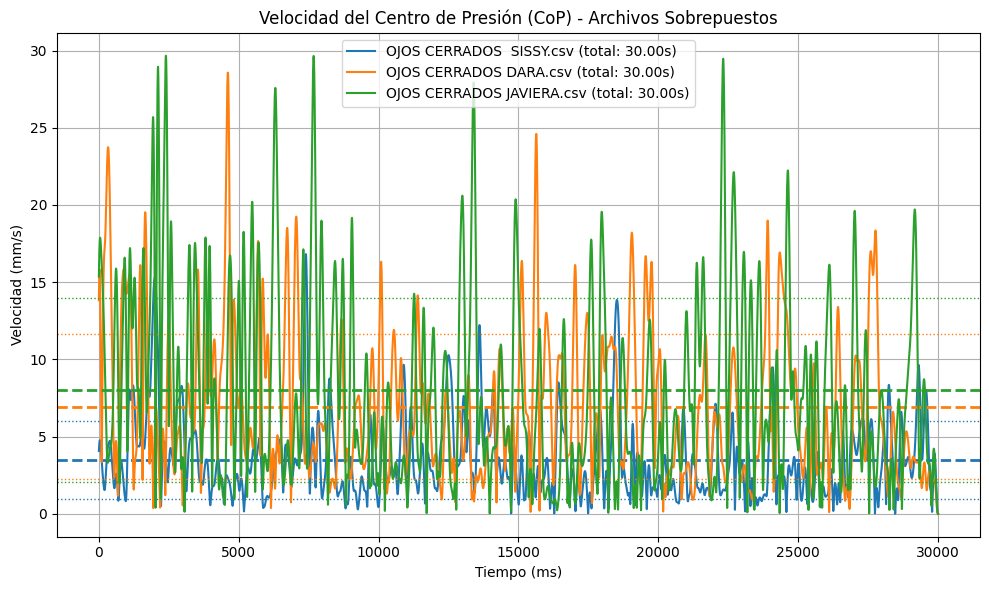

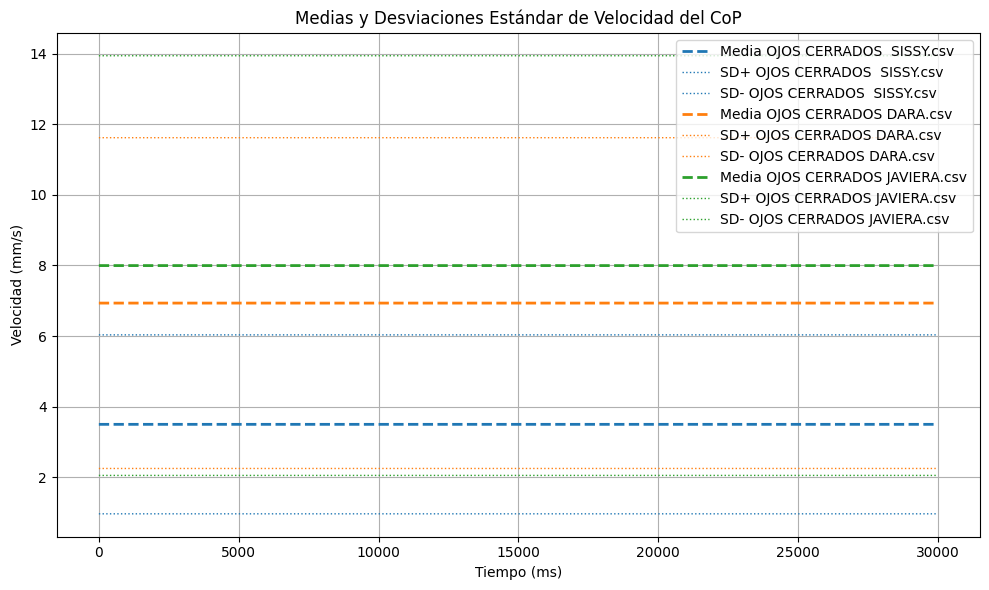

In [29]:
# ESTE SCRIPT FUNCIONA AL EXPORTAR DESDE VICON SÓLO LOS Cx y Cy de la plataforma en el pipeline
# Se ha incorporado la separación del overlay
# Versión: 1.1

# Importar librerías necesarias
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

# Función para cargar y listar archivos
def cargar_archivos():
    from google.colab import files
    uploaded = files.upload()
    archivos = list(uploaded.keys())
    return archivos

# Función para seleccionar un archivo
def seleccionar_archivo(archivos):
    while True:
        print("Archivos disponibles:")
        for idx, archivo in enumerate(archivos):
            print(f"{idx + 1}. {archivo}")
        print("u. Cargar un nuevo archivo")
        print("a. Analizar todos los archivos")
        print("o. Graficar archivos sobrepuestos")

        seleccion = input("Ingrese el número del archivo que desea analizar, 'u' para cargar un nuevo archivo, 'a' para analizar todos los archivos, o 'o' para graficar archivos sobrepuestos: ").strip().lower()

        if seleccion == 'u':
            nuevos_archivos = cargar_archivos()
            archivos.extend(nuevos_archivos)
        elif seleccion == 'a':
            return 'all'
        elif seleccion == 'o':
            if len(archivos) < 2:
                print("Debe cargar al menos dos archivos para sobreponer.")
                continue
            seleccion_archivos = input("Ingrese los números de los archivos que desea sobreponer, separados por coma: ").strip().lower()
            seleccion_indices = [int(i) - 1 for i in seleccion_archivos.split(',') if i.isdigit() and 1 <= int(i) <= len(archivos)]
            if seleccion_indices:
                return [archivos[i] for i in seleccion_indices]
            else:
                print("Selección no válida. Inténtelo de nuevo.")
        elif seleccion.isdigit() and 1 <= int(seleccion) <= len(archivos):
            return archivos[int(seleccion) - 1]
        else:
            print("Selección no válida. Inténtelo de nuevo.")

# Función para verificar y obtener columnas de datos
def obtener_columnas(data, columns):
    if 'Cx' in columns and 'Cy' in columns:
        cx_col = 'Cx'
        cy_col = 'Cy'
    else:
        print("Columnas disponibles:", columns)
        cx_col = input("Ingrese el nombre de la columna para Cx: ")
        cy_col = input("Ingrese el nombre de la columna para Cy: ")
    return cx_col, cy_col

# Función para aplicar filtro de paso bajo
def aplicar_filtro_paso_bajo(data, column, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data[column])
    return y

# Función para calcular la velocidad del CoP
def calcular_velocidad(data, cx_col, cy_col, sampling_frequency):
    data['dx'] = data[cx_col].diff()
    data['dy'] = data[cy_col].diff()
    data['dt'] = 1 / sampling_frequency
    data['velocidad'] = np.sqrt(data['dx']**2 + data['dy']**2) / data['dt']
    return data

# Función para procesar el archivo seleccionado
def procesar_archivo(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()

    # Extraer la frecuencia de muestreo (línea 2)
    sampling_frequency = int(lines[1].strip().split(',')[0])

    # Leer los encabezados (línea 4)
    columns = lines[3].strip().split(',')

    # Leer las unidades (línea 5)
    units = lines[4].strip().split(',')

    # Leer los datos (desde la línea 6 en adelante)
    data = pd.DataFrame([line.strip().split(',') for line in lines[5:]], columns=columns)

    # Convertir las columnas a numéricas donde sea posible
    for column in data.columns:
        try:
            data[column] = pd.to_numeric(data[column], errors='coerce')
        except Exception as e:
            print(f"Error convirtiendo la columna {column}: {e}")

    # Eliminar filas con valores NaN
    data.dropna(subset=['Cx', 'Cy'], inplace=True)

    # Calcular el tiempo total de muestreo y crear una nueva columna 't ms'
    num_rows = len(data)  # Número total de filas
    total_time_s = num_rows / sampling_frequency  # Tiempo total en segundos
    data['t ms'] = (data.index / sampling_frequency) * 1000  # Tiempo en milisegundos para cada fila

    # Obtener las columnas para Cx y Cy
    cx_col, cy_col = obtener_columnas(data, columns)

    # Aplicar filtro de paso bajo
    cutoff_frequency = 5  # Frecuencia de corte en Hz
    data[f'{cx_col} (low pass {cutoff_frequency} Hz)'] = aplicar_filtro_paso_bajo(data, cx_col, cutoff_frequency, sampling_frequency)
    data[f'{cy_col} (low pass {cutoff_frequency} Hz)'] = aplicar_filtro_paso_bajo(data, cy_col, cutoff_frequency, sampling_frequency)

    # Calcular la velocidad del CoP sobre la señal filtrada
    data = calcular_velocidad(data, f'{cx_col} (low pass {cutoff_frequency} Hz)', f'{cy_col} (low pass {cutoff_frequency} Hz)', sampling_frequency)

    return data, total_time_s

# Función para graficar un archivo individual
def graficar_individual(data, total_time_s, file_name):
    # Crear un gradiente de color basado en el tiempo
    norm = plt.Normalize(data['t ms'].min(), data['t ms'].max())
    cmap = plt.get_cmap('viridis')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Visualizar los datos originales del CoP con un gradiente de color
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Cx'], data['Cy'], c=data['t ms'], cmap=cmap, norm=norm, s=10)
    plt.colorbar(sm, label='Tiempo (ms)')
    plt.xlabel('Cx (mm)')
    plt.ylabel('Cy (mm)')
    plt.title(f'Desplazamiento del Centro de Presión (CoP) - {file_name}')
    plt.text(0.95, 0.05, f'Tiempo total: {total_time_s:.3f} s', horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.5'))
    plt.grid(True)
    plt.show()

    # Visualizar los datos filtrados del CoP con un gradiente de color
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Cx (low pass 5 Hz)'], data['Cy (low pass 5 Hz)'], c=data['t ms'], cmap=cmap, norm=norm, s=10)
    plt.colorbar(sm, label='Tiempo (ms)')
    plt.xlabel('Cx (low pass 5 Hz) (mm)')
    plt.ylabel('Cy (low pass 5 Hz) (mm)')
    plt.title(f'Desplazamiento del Centro de Presión (CoP) - Señal Filtrada (Low Pass 5 Hz) - {file_name}')
    plt.text(0.95, 0.05, f'Tiempo total: {total_time_s:.3f} s (señal filtrada, low pass 5 Hz)', horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.5'))
    plt.grid(True)
    plt.show()

    # Crear un gráfico con dos subgráficos: línea de velocidad y dispersión con color
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Subgráfico 1: Gráfico de líneas de velocidad
    axs[0].plot(data['t ms'], data['velocidad'], color='b', label='Velocidad')
    axs[0].set_xlabel('Tiempo (ms)')
    axs[0].set_ylabel('Velocidad (mm/s)')
    axs[0].set_title('Velocidad del Centro de Presión (CoP) a lo largo del tiempo')
    axs[0].legend()
    axs[0].grid(True)

    # Subgráfico 2: Gráfico de dispersión con color representando la velocidad
    scatter = axs[1].scatter(data['Cx (low pass 5 Hz)'], data['Cy (low pass 5 Hz)'], c=data['velocidad'], cmap='viridis', s=10)
    axs[1].set_xlabel('Cx (low pass 5 Hz) (mm)')
    axs[1].set_ylabel('Cy (low pass 5 Hz) (mm)')
    axs[1].set_title('Desplazamiento del Centro de Presión (CoP) con velocidad')
    cbar = fig.colorbar(scatter, ax=axs[1], label='Velocidad (mm/s)')
    axs[1].grid(True)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Función para graficar archivos sobrepuestos
def graficar_sobrepuestos(archivos_cargados):
    fig, ax = plt.subplots(figsize=(10, 6))

    for archivo in archivos_cargados:
        data, total_time_s = procesar_archivo(archivo)
        line = ax.plot(data['t ms'], data['velocidad'], label=f'{archivo} (total: {total_time_s:.2f}s)')

        # Agregar línea gruesa en la media de la serie
        color = line[0].get_color()
        media_velocidad = data['velocidad'].mean()
        std_velocidad = data['velocidad'].std()

        # Línea media
        ax.axhline(y=media_velocidad, color=color, linestyle='--', linewidth=2)

        # Líneas de desviación estándar
        ax.axhline(y=media_velocidad + std_velocidad, color=color, linestyle=':', linewidth=1)
        ax.axhline(y=media_velocidad - std_velocidad, color=color, linestyle=':', linewidth=1)

    ax.set_xlabel('Tiempo (ms)')
    ax.set_ylabel('Velocidad (mm/s)')
    ax.set_title('Velocidad del Centro de Presión (CoP) - Archivos Sobrepuestos')
    ax.legend()
    ax.grid(True)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Función para graficar medias y desviaciones estándar
def graficar_medias_y_sd(archivos_seleccionados):
    fig, ax = plt.subplots(figsize=(10, 6))

    for archivo in archivos_seleccionados:
        data, total_time_s = procesar_archivo(archivo)
        color = next(ax._get_lines.prop_cycler)['color']
        media_velocidad = data['velocidad'].mean()
        std_velocidad = data['velocidad'].std()

        # Graficar media
        ax.plot(data['t ms'], [media_velocidad]*len(data), label=f'Media {archivo}', color=color, linestyle='--', linewidth=2)

        # Graficar desviaciones estándar
        ax.plot(data['t ms'], [media_velocidad + std_velocidad]*len(data), color=color, linestyle=':', linewidth=1, label=f'SD+ {archivo}')
        ax.plot(data['t ms'], [media_velocidad - std_velocidad]*len(data), color=color, linestyle=':', linewidth=1, label=f'SD- {archivo}')

    ax.set_xlabel('Tiempo (ms)')
    ax.set_ylabel('Velocidad (mm/s)')
    ax.set_title('Medias y Desviaciones Estándar de Velocidad del CoP')
    ax.legend()
    ax.grid(True)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Listar archivos ya cargados en Google Colab
archivos_cargados = [f for f in os.listdir('.') if os.path.isfile(f)]

# Cargar y listar archivos si no hay archivos cargados
if not archivos_cargados:
    archivos_cargados = cargar_archivos()

# Seleccionar un archivo para analizar
archivo_seleccionado = seleccionar_archivo(archivos_cargados)

# Procesar el archivo seleccionado o todos los archivos
if archivo_seleccionado == 'all':
    for archivo in archivos_cargados:
        data, total_time_s = procesar_archivo(archivo)
        graficar_individual(data, total_time_s, archivo)
elif isinstance(archivo_seleccionado, list):
    graficar_sobrepuestos(archivo_seleccionado)
    graficar_medias_y_sd(archivo_seleccionado)
else:
    data, total_time_s = procesar_archivo(archivo_seleccionado)
    graficar_individual(data, total_time_s, archivo_seleccionado)


Archivos disponibles:
1. OJOS ABIERTOS DARA.csv
2. OJOS CERRADOS  SISSY.csv
3. OJOS ABIERTO JAVIERA.csv
4. OJOS CERRADOS DARA.csv
5. OJOS CERRADOS JAVIERA.csv
u. Cargar un nuevo archivo
a. Analizar todos los archivos
o. Graficar archivos sobrepuestos
Ingrese el número del archivo que desea analizar, 'u' para cargar un nuevo archivo, 'a' para analizar todos los archivos, o 'o' para graficar archivos sobrepuestos: o
Ingrese los números de los archivos que desea sobreponer, separados por coma: 1,4,5


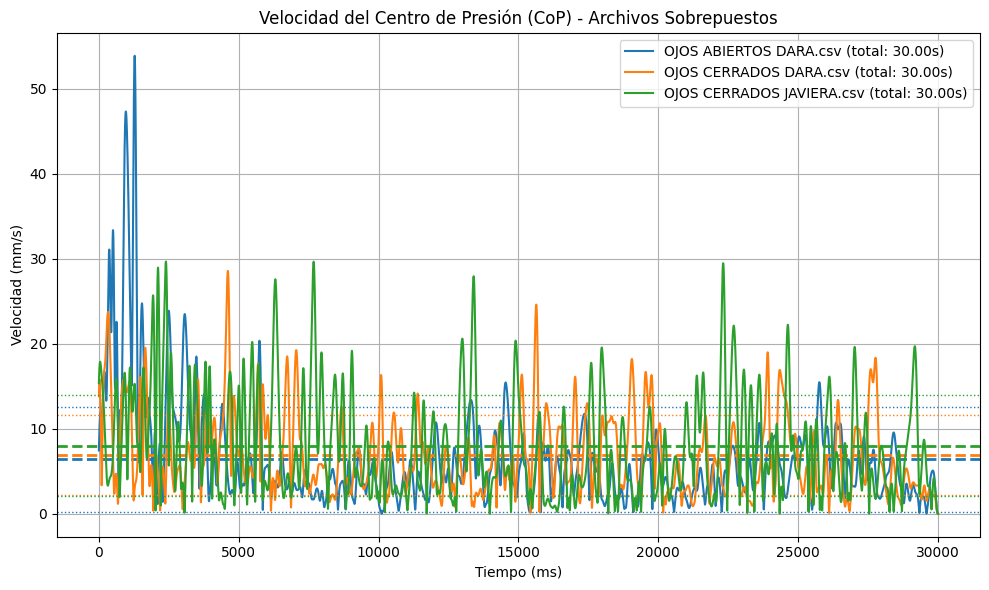

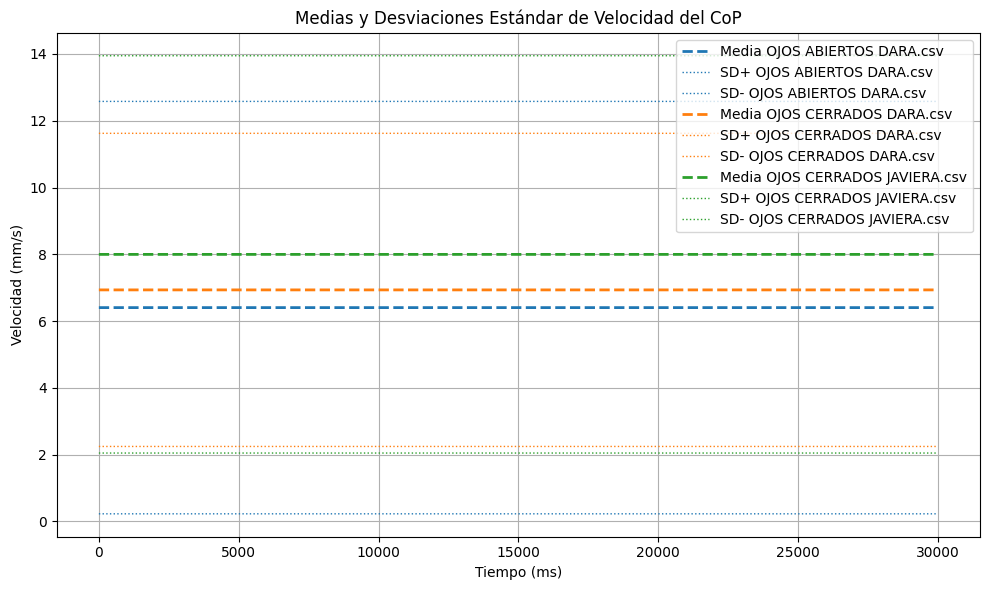

In [30]:
#ver2
# ESTE SCRIPT FUNCIONA AL EXPORTAR DESDE VICON SÓLO LOS Cx y Cy de la plataforma en el pipeline
# Se ha incorporado la separación del overlay
# Versión: 1.1

# Importar librerías necesarias
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

# Función para cargar y listar archivos
def cargar_archivos():
    from google.colab import files
    uploaded = files.upload()
    archivos = list(uploaded.keys())
    return archivos

# Función para seleccionar un archivo
def seleccionar_archivo(archivos):
    while True:
        print("Archivos disponibles:")
        for idx, archivo in enumerate(archivos):
            print(f"{idx + 1}. {archivo}")
        print("u. Cargar un nuevo archivo")
        print("a. Analizar todos los archivos")
        print("o. Graficar archivos sobrepuestos")

        seleccion = input("Ingrese el número del archivo que desea analizar, 'u' para cargar un nuevo archivo, 'a' para analizar todos los archivos, o 'o' para graficar archivos sobrepuestos: ").strip().lower()

        if seleccion == 'u':
            nuevos_archivos = cargar_archivos()
            archivos.extend(nuevos_archivos)
        elif seleccion == 'a':
            return 'all'
        elif seleccion == 'o':
            if len(archivos) < 2:
                print("Debe cargar al menos dos archivos para sobreponer.")
                continue
            seleccion_archivos = input("Ingrese los números de los archivos que desea sobreponer, separados por coma: ").strip().lower()
            seleccion_indices = [int(i) - 1 for i in seleccion_archivos.split(',') if i.isdigit() and 1 <= int(i) <= len(archivos)]
            if seleccion_indices:
                return [archivos[i] for i in seleccion_indices]
            else:
                print("Selección no válida. Inténtelo de nuevo.")
        elif seleccion.isdigit() and 1 <= int(seleccion) <= len(archivos):
            return archivos[int(seleccion) - 1]
        else:
            print("Selección no válida. Inténtelo de nuevo.")

# Función para verificar y obtener columnas de datos
def obtener_columnas(data, columns):
    if 'Cx' in columns and 'Cy' in columns:
        cx_col = 'Cx'
        cy_col = 'Cy'
    else:
        print("Columnas disponibles:", columns)
        cx_col = input("Ingrese el nombre de la columna para Cx: ")
        cy_col = input("Ingrese el nombre de la columna para Cy: ")
    return cx_col, cy_col

# Función para aplicar filtro de paso bajo
def aplicar_filtro_paso_bajo(data, column, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data[column])
    return y

# Función para calcular la velocidad del CoP
def calcular_velocidad(data, cx_col, cy_col, sampling_frequency):
    data['dx'] = data[cx_col].diff()
    data['dy'] = data[cy_col].diff()
    data['dt'] = 1 / sampling_frequency
    data['velocidad'] = np.sqrt(data['dx']**2 + data['dy']**2) / data['dt']
    return data

# Función para procesar el archivo seleccionado
def procesar_archivo(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()

    # Extraer la frecuencia de muestreo (línea 2)
    sampling_frequency = int(lines[1].strip().split(',')[0])

    # Leer los encabezados (línea 4)
    columns = lines[3].strip().split(',')

    # Leer las unidades (línea 5)
    units = lines[4].strip().split(',')

    # Leer los datos (desde la línea 6 en adelante)
    data = pd.DataFrame([line.strip().split(',') for line in lines[5:]], columns=columns)

    # Convertir las columnas a numéricas donde sea posible
    for column in data.columns:
        try:
            data[column] = pd.to_numeric(data[column], errors='coerce')
        except Exception as e:
            print(f"Error convirtiendo la columna {column}: {e}")

    # Eliminar filas con valores NaN
    data.dropna(subset=['Cx', 'Cy'], inplace=True)

    # Calcular el tiempo total de muestreo y crear una nueva columna 't ms'
    num_rows = len(data)  # Número total de filas
    total_time_s = num_rows / sampling_frequency  # Tiempo total en segundos
    data['t ms'] = (data.index / sampling_frequency) * 1000  # Tiempo en milisegundos para cada fila

    # Obtener las columnas para Cx y Cy
    cx_col, cy_col = obtener_columnas(data, columns)

    # Aplicar filtro de paso bajo
    cutoff_frequency = 5  # Frecuencia de corte en Hz
    data[f'{cx_col} (low pass {cutoff_frequency} Hz)'] = aplicar_filtro_paso_bajo(data, cx_col, cutoff_frequency, sampling_frequency)
    data[f'{cy_col} (low pass {cutoff_frequency} Hz)'] = aplicar_filtro_paso_bajo(data, cy_col, cutoff_frequency, sampling_frequency)

    # Calcular la velocidad del CoP sobre la señal filtrada
    data = calcular_velocidad(data, f'{cx_col} (low pass {cutoff_frequency} Hz)', f'{cy_col} (low pass {cutoff_frequency} Hz)', sampling_frequency)

    return data, total_time_s

# Función para graficar un archivo individual
def graficar_individual(data, total_time_s, file_name):
    # Crear un gradiente de color basado en el tiempo
    norm = plt.Normalize(data['t ms'].min(), data['t ms'].max())
    cmap = plt.get_cmap('viridis')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Visualizar los datos originales del CoP con un gradiente de color
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Cx'], data['Cy'], c=data['t ms'], cmap=cmap, norm=norm, s=10)
    plt.colorbar(sm, label='Tiempo (ms)')
    plt.xlabel('Cx (mm)')
    plt.ylabel('Cy (mm)')
    plt.title(f'Desplazamiento del Centro de Presión (CoP) - {file_name}')
    plt.text(0.95, 0.05, f'Tiempo total: {total_time_s:.3f} s', horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.5'))
    plt.grid(True)
    plt.show()

    # Visualizar los datos filtrados del CoP con un gradiente de color
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Cx (low pass 5 Hz)'], data['Cy (low pass 5 Hz)'], c=data['t ms'], cmap=cmap, norm=norm, s=10)
    plt.colorbar(sm, label='Tiempo (ms)')
    plt.xlabel('Cx (low pass 5 Hz) (mm)')
    plt.ylabel('Cy (low pass 5 Hz) (mm)')
    plt.title(f'Desplazamiento del Centro de Presión (CoP) - Señal Filtrada (Low Pass 5 Hz) - {file_name}')
    plt.text(0.95, 0.05, f'Tiempo total: {total_time_s:.3f} s (señal filtrada, low pass 5 Hz)', horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.5'))
    plt.grid(True)
    plt.show()

    # Crear un gráfico con dos subgráficos: línea de velocidad y dispersión con color
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Subgráfico 1: Gráfico de líneas de velocidad
    axs[0].plot(data['t ms'], data['velocidad'], color='b', label='Velocidad')
    axs[0].set_xlabel('Tiempo (ms)')
    axs[0].set_ylabel('Velocidad (mm/s)')
    axs[0].set_title('Velocidad del Centro de Presión (CoP) a lo largo del tiempo')
    axs[0].legend()
    axs[0].grid(True)

      # Subgráfico 2: Gráfico de dispersión con color representando la velocidad
    scatter = axs[1].scatter(data['Cx (low pass 5 Hz)'], data['Cy (low pass 5 Hz)'], c=data['velocidad'], cmap='viridis', s=10)
    axs[1].set_xlabel('Cx (low pass 5 Hz) (mm)')
    axs[1].set_ylabel('Cy (low pass 5 Hz) (mm)')
    axs[1].set_title('Desplazamiento del Centro de Presión (CoP) con velocidad')
    cbar = fig.colorbar(scatter, ax=axs[1], label='Velocidad (mm/s)')
    axs[1].grid(True)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Función para graficar archivos sobrepuestos
def graficar_sobrepuestos(archivos_cargados):
    fig, ax = plt.subplots(figsize=(10, 6))

    for archivo in archivos_cargados:
        data, total_time_s = procesar_archivo(archivo)
        line = ax.plot(data['t ms'], data['velocidad'], label=f'{archivo} (total: {total_time_s:.2f}s)')

        # Agregar línea gruesa en la media de la serie
        color = line[0].get_color()
        media_velocidad = data['velocidad'].mean()
        std_velocidad = data['velocidad'].std()

        # Línea media
        ax.axhline(y=media_velocidad, color=color, linestyle='--', linewidth=2)

        # Líneas de desviación estándar
        ax.axhline(y=media_velocidad + std_velocidad, color=color, linestyle=':', linewidth=1)
        ax.axhline(y=media_velocidad - std_velocidad, color=color, linestyle=':', linewidth=1)

    ax.set_xlabel('Tiempo (ms)')
    ax.set_ylabel('Velocidad (mm/s)')
    ax.set_title('Velocidad del Centro de Presión (CoP) - Archivos Sobrepuestos')
    ax.legend()
    ax.grid(True)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Función para graficar medias y desviaciones estándar
def graficar_medias_y_sd(archivos_seleccionados):
    fig, ax = plt.subplots(figsize=(10, 6))

    for archivo in archivos_seleccionados:
        data, total_time_s = procesar_archivo(archivo)
        color = next(ax._get_lines.prop_cycler)['color']
        media_velocidad = data['velocidad'].mean()
        std_velocidad = data['velocidad'].std()

        # Graficar media
        ax.plot(data['t ms'], [media_velocidad]*len(data), label=f'Media {archivo}', color=color, linestyle='--', linewidth=2)

        # Graficar desviaciones estándar
        ax.plot(data['t ms'], [media_velocidad + std_velocidad]*len(data), color=color, linestyle=':', linewidth=1, label=f'SD+ {archivo}')
        ax.plot(data['t ms'], [media_velocidad - std_velocidad]*len(data), color=color, linestyle=':', linewidth=1, label=f'SD- {archivo}')

    ax.set_xlabel('Tiempo (ms)')
    ax.set_ylabel('Velocidad (mm/s)')
    ax.set_title('Medias y Desviaciones Estándar de Velocidad del CoP')
    ax.legend()
    ax.grid(True)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Listar archivos ya cargados en Google Colab
archivos_cargados = [f for f in os.listdir('.') if os.path.isfile(f)]

# Cargar y listar archivos si no hay archivos cargados
if not archivos_cargados:
    archivos_cargados = cargar_archivos()

# Seleccionar un archivo para analizar
archivo_seleccionado = seleccionar_archivo(archivos_cargados)

# Procesar el archivo seleccionado o todos los archivos
if archivo_seleccionado == 'all':
    for archivo in archivos_cargados:
        data, total_time_s = procesar_archivo(archivo)
        graficar_individual(data, total_time_s, archivo)
elif isinstance(archivo_seleccionado, list):
    graficar_sobrepuestos(archivo_seleccionado)
    graficar_medias_y_sd(archivo_seleccionado)
else:
    data, total_time_s = procesar_archivo(archivo_seleccionado)
    graficar_individual(data, total_time_s, archivo_seleccionado)
